In [1]:
#モジュール、パッケージのインポート
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import xarray

from sklearn import datasets

import time

import multiprocessing
multiprocessing.cpu_count()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


48

In [2]:
#jaxでcpuの並列処理するための準備

# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=48'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15), CpuDevice(id=16), CpuDevice(id=17), CpuDevice(id=18), CpuDevice(id=19), CpuDevice(id=20), CpuDevice(id=21), CpuDevice(id=22), CpuDevice(id=23), CpuDevice(id=24), CpuDevice(id=25), CpuDevice(id=26), CpuDevice(id=27), CpuDevice(id=28), CpuDevice(id=29), CpuDevice(id=30), CpuDevice(id=31), CpuDevice(id=32), CpuDevice(id=33), CpuDevice(id=34), CpuDevice(id=35), CpuDevice(id=36), CpuDevice(id=37), CpuDevice(id=38), CpuDevice(id=39), CpuDevice(id=40), CpuDevice(id=41), CpuDevice(id=42), CpuDevice(id=43), CpuDevice(id=44), CpuDevice(id=45), CpuDevice(id=46), CpuDevice(id=47)]


## べイズ線形単回帰

### トイデータ作成

In [3]:
np.random.seed(1)
N = 10
alpha_real = 2.5
beta_real = 0.4
sigma_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(0, 3, N)
y_real = alpha_real + beta_real * x
y = y_real + sigma_real

print(f"x:{x}")
print(f"y:{y}")

x:[ 4.38632381 -6.18042213 -0.96725161 -1.15216306  3.40130833 -3.2996738
 -0.51728462 -2.63357525  0.12664124  1.74844564]
y:[ 5.06670221 -0.27804706  1.84901348  1.50265046  4.29322715  0.02936113
  3.16549203  1.06596645  2.71017604  3.07469307]


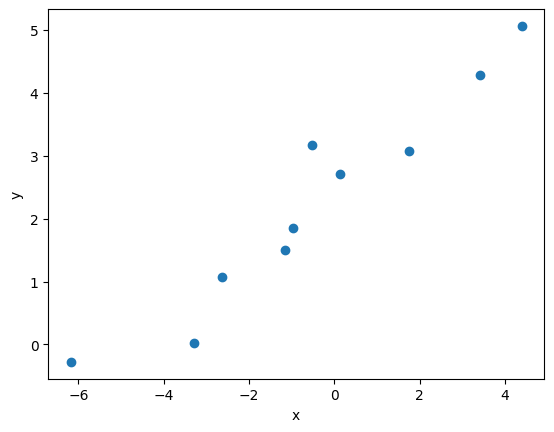

In [4]:
#データの可視化
plt.figure()
plt.scatter(x,y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### 決定論的な手法

Slope: 0.5302410594089594, Intercept: 2.517691666247418
R-squared: 0.9259008661595178


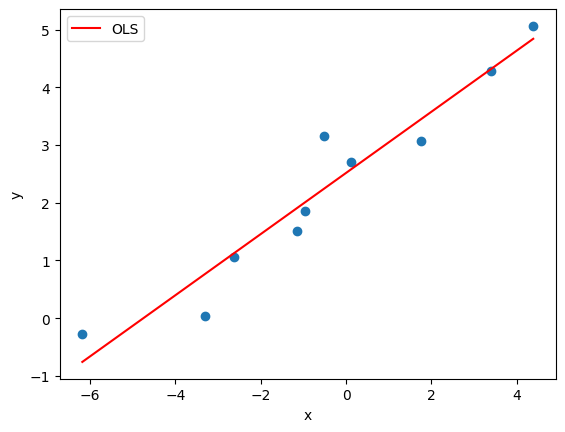

In [5]:
# Scipyを使って、最小二乗法で切片αと勾配βの推定(決定論的手法)
from scipy.stats import linregress

# 線形回帰の適用
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# 結果の表示
print(f"Slope: {slope}, Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

plt.figure()
plt.scatter(x,y)
plt.plot(np.linspace(x.min(),x.max(),10),slope*np.linspace(x.min(),x.max(),10)+intercept,c="r",label="OLS")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### ベイズ的手法

L2正則化は、事後分布を最大化するようなパラメータが最良であるとする事後確率最大化(MAP; Maximum A Posteriori)}という考え方に従ってパラメータを
決定していることと等価

⇒MAP推定はリッジ回帰に一致するするので、ベイズ線形回帰はRidge回帰+予測の不確実性をモデリングしているという理解でOK

https://hkashima.github.io/2-2.pdf

#### モデリング

In [6]:
#モデルの作成
with pm.Model() as model_linear:
    # MutableDataコンテナにデータを格納
    x_data=pm.MutableData('x_data', x.flatten())
    y_data=pm.MutableData('y_data', y)
    
    #事前分布の設定
    alpha = pm.Normal('alpha', mu=0, sigma=3)#alpha ~ Normal(0,3)
    beta = pm.Normal('beta', mu=0, sigma=3)#beta ~ Normal(0,3)
    sigma = pm.HalfNormal('sigma',sigma=3)#sigma ~ HalfNormal(3)
    
    #線形予測子
    mu = pm.Deterministic('mu', alpha + beta * x_data)#μ = α + β * x
    
    #尤度関数
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_data)#y ~ Normal(mu,sigma)

/home/tsujimoto/.conda/envs/pymcextras/lib/python3.10/site-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


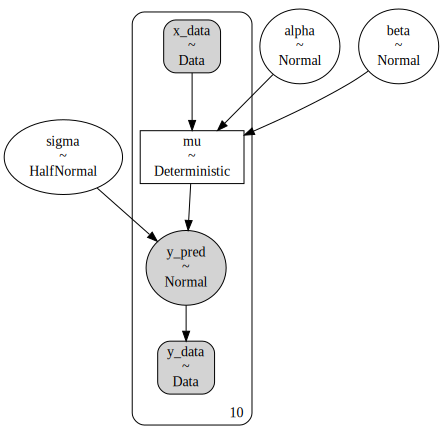

In [7]:
# モデル構造の図示化 (グラフィカルモデル作成)
pm.model_to_graphviz(model_linear)

グラフィカルモデルをみることで各つながりが可視化できます。モデルの間違えに気づきやすくなります。

#### まずは事前分布からパラメータalpha(切片), beta(勾配)をサンプリング

In [8]:
with model_linear:
    idata = pm.sample_prior_predictive(draws=100, random_seed=42)

Sampling: [alpha, beta, sigma, y_pred]


/tmp/ipykernel_290160/1241299117.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


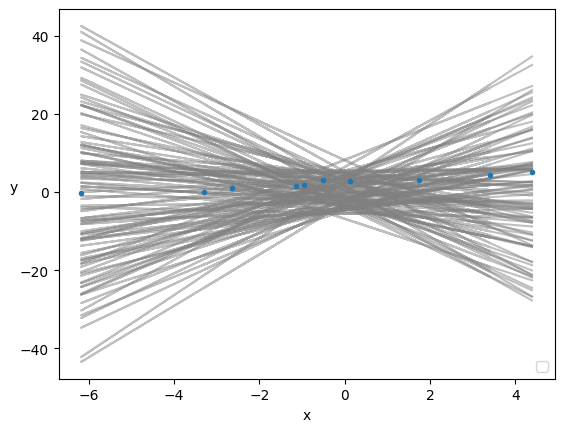

In [9]:
#事前分布からパラメータをサンプリングP(Θ)

prior = idata.prior
alpha_p = prior['alpha'].mean().item()
beta_p = prior['beta'].mean().item()
plt.plot(x, prior['alpha'].values + prior['beta'].values * x.reshape(-1,1), c='gray', alpha=0.5)

plt.plot(x, y, 'C0.')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc='lower right')
plt.show()

事前分布は人が設定したもので、与えた事前分布の範囲で様々なパラメータalpha, betaがサンプリングされている。

#### データで事前分布を更新し、パラメータの事後分布を得る

In [ ]:
%time
#サンプリング
with model_linear:#バーンインが2000サンプルで2000サンプルを4チェイン実行、16000サンプリングしている
    # trace = pm.sample(2000, tune= 2000, nuts_sampler="pymc", chains=4)#サンプラーはpymcのデフォルト、省略も可能
    trace = pm.sample(2000, tune=2000, nuts_sampler="numpyro",chains=4)#(このモデルではシンプルすぎて恩恵がわからないが)numpyroをバックエンドに使うと爆速、ただしMCMCのサンプリングがnutsの時(サンプリングパラメータが連続値)の時のみしか使えない

CPU times: user 4 μs, sys: 5 μs, total: 9 μs
Wall time: 19.3 μs


#### 得られた事後分布の可視化

pymcでサンプリングした事後分布の図示化は基本的には、arvizで1行コードで可視化できます - 便利！

In [ ]:
#サンプリング結果の可視化
az.plot_trace(trace)

In [ ]:
#事後分布だけを可視化
# az.plot_posterior(trace)
az.plot_posterior(trace,var_names=["alpha","beta","sigma"])

In [ ]:
#事後分布の情報をテーブル型で表示

pm.summary(trace)
# pm.summary(trace,var_names=["alpha","beta","sigma"])

#r_hatが1.05以下ならmcmcの収束は問題なく、定常分布になっていると判断できます。

In [ ]:
#個人的にはこの図が見やすい(plot_forest)
# az.plot_forest(trace,combined=True, hdi_prob=0.94, r_hat=True)
az.plot_forest(trace,combined=True,var_names=["alpha","beta","sigma"], hdi_prob=0.94, r_hat=True)

#例えば、勾配betaのHDI94%が0にまでかかっていると、94%内の確率で傾きが0になる可能性があるので、このxは必ずしも正に寄与していると断定しない方がよい。今回の結果は、HDIが0を
#含んでいないので、自信を持ってxは正に寄与していると言ってよい。

In [ ]:
#alpha,betaの事後分布を使ってプロット
posterior_g = az.extract(trace)
alpha_m = posterior_g['alpha'].mean().item()
beta_m = posterior_g['beta'].mean().item()
draws = range(0, posterior_g.sample.size, 10)
plt.plot(x, posterior_g['alpha'][draws].values + posterior_g['beta'][draws].values * x.reshape(-1,1), c='gray', alpha=0.5)

plt.plot(x, y, 'C0.')

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x (MAP)')

plt.plot(np.linspace(x.min(),x.max(),10),slope*np.linspace(x.min(),x.max(),10)+intercept,c="r",label=f'y = {intercept:.2f} + {slope:.2f} * x (ML)')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc='lower right')
plt.show()

データによってalpha, betaが事前分布からベイズ更新され、事後分布が得られます。事後分布のほうが同じxでも取りうるyの値が狭くなっていることがわかります。

#### ベイズ信頼区間(Θ|y)とベイズ予測区間(y_new|y)の可視化

In [ ]:
#ベイズ信頼区間 p(Θ|y)#誤差を含まないのでデータが多い点ほど信頼区間が狭くなる
plt.plot(x, y, 'C0.')

# plt.plot(x, y_ml, 'r--', label=f'y = {intercept:.2f} + {slope:.2f} * x (ML)')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x (MAP)')

sig = az.plot_hdi(x.flatten(), posterior_g['mu'].T, hdi_prob=0.94, color='k')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc='lower right')

In [ ]:
#事後分布からサンプル発生させる。
ppc = pm.sample_posterior_predictive(trace, model=model_linear)

In [ ]:
#ベイズ予測区間 p(y_new|y)で誤差を含む
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x.flatten(), ppc.posterior_predictive['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x.flatten(), ppc.posterior_predictive['y_pred'], hdi_prob=0.94,color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()


## ベイズ線形重回帰

### トイデータ作成

In [ ]:
#トイデータを作成
np.random.seed(1)
N = (10,3)#データ数, 特徴量数
alpha_real = 3#切片
beta_real = np.array([1.3,0.5,-0.7])#勾配
sigma_real = np.random.normal(0, 0.6, size=N[0])

X = np.random.normal(0, N[1], N)
y_real = alpha_real + np.dot(X,beta_real)
y = y_real + sigma_real

X=pd.DataFrame(X,columns=["x0","x1","x2"])#pd.DataFrameに変換
display(X)
print(y)

In [ ]:
for i in range(len(X.columns)):
    plt.scatter(X.iloc[:,i],y,label=X.columns[i])
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

### モデリング

In [ ]:
#モデルの構築
coords={"col":X.columns.tolist()}#特徴量の名前をcoordsという形で与えておく

with pm.Model(coords=coords) as model_multi:
    # MutableDataコンテナにデータを格納
    X_data=pm.MutableData('X_data', X)
    y_data=pm.MutableData('y_data', y)
    
    # 事前分布の設定
    alpha = pm.Normal('alpha', mu=0, sigma=3)
    beta = pm.Normal('beta', mu=0, sigma=3, dims="col") #Baysian Ridge(L2)
    # beta = pm.Laplace('beta', mu=0, b=3, dims="col") #Baysian Lasso(L1)

    sigma = pm.HalfNormal('sigma',sigma=1)#sigma 
    
    
    # 線形予測子
    mu = pm.Deterministic("mu",alpha + pm.math.dot(X_data, beta))
    
    #尤度関数
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_data)#y ~ Normal(mu,sigma)
    # y_pred = pm.Cauchy('y_pred', alpha=mu, beta=1, observed=y_data) # Robust Linear Regression(外れ値に堅牢)

In [ ]:
# モデル構造の図示化 (グラフィカルモデル作成)
pm.model_to_graphviz(model_multi)

In [ ]:
%time
#サンプリング
with model_multi:        
    trace_multi = pm.sample(2000, tune=2000, nuts_sampler="numpyro",chains=4)

### 可視化

In [ ]:
#事後分布だけを可視化
# az.plot_posterior(trace)
az.plot_posterior(trace_multi,var_names=["alpha","beta","sigma"])

In [ ]:
#事後分布の情報をテーブル型で表示
pm.summary(trace_multi,var_names=["alpha","beta","sigma"])

In [ ]:
#個人的にはこの図が見やすい(plot_forest)
az.plot_forest(trace_multi,combined=True,var_names=["alpha","beta","sigma"], hdi_prob=0.94, r_hat=True)

### 事後分布からのサンプリング

In [ ]:
with model_multi:#事後分布を使ってサンプリング
    ppc_multi=pm.sample_posterior_predictive(trace_multi)

In [ ]:
#yy-plot を書いてみる
mcmc_sample = np.array(ppc_multi.posterior_predictive.to_dataarray()).squeeze()[i].reshape(-1, len(X.index))
mcmc_sample.shape

# 予測値と実測値のプロット
quantile = [10, 50, 90]
colname = ['p' + str(x) for x in quantile]
# パーセンタイルを計算してデータフレームに変換
data3a_pred = pd.DataFrame(np.percentile(mcmc_sample, q=quantile, axis=0).T, columns=colname, index=X.index)
data3a_pred
d = pd.concat([X, data3a_pred], axis=1)

# プロットの設定
plt.figure(figsize=(6, 6))
plt.errorbar(y, d.p50, 
             yerr=[d.p50 - d.p10, d.p90 - d.p50],
             fmt='o', ecolor='gray', ms=10, alpha=0.8, marker='o', mfc="red", capsize=3)

# 対角線のプロット
plt.plot([y.min(),y.max()], [y.min(),y.max()], 'k--', alpha=0.7)
# ラベルとタイトル
plt.xlabel('Observed', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.legend()
plt.title("yyplot")
# プロットの表示
plt.show()

##　ベイズロジスティック回帰

### トイデータ作成(IRISを利用)

In [ ]:
#トイデータとしてIrisデータを使用

from sklearn import datasets

# Irisデータセットをロード
iris = datasets.load_iris()

# 特徴量とラベル名を表示
print("Features: ", iris.feature_names)
print("Labels: ", iris.target_names)

# DataFrameに変換
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

# データの最初の数行を表示
display(iris_df.head())


In [ ]:
#ロジスティック回帰をするためには2値分類
df=iris_df.query("species ==(0,1)")
print(df.shape)

In [ ]:
#特徴量の数も2つにする
df = iris_df.query("species == (0, 1)")
y_0 = pd.Categorical(df['species']).codes
x_n =["sepal length (cm)","sepal width (cm)"] #とりあえず説明変数は"sepal length (cm)" ,"sepal width (cm)"に限定
x_0 = df[x_n].values
x_std = (x_0 - x_0.mean())/x_0.std()#標準化


### モデリング

In [ ]:
#モデルの構築
coords={"col":x_n}

with pm.Model(coords=coords) as model_lr:
    # MutableDataコンテナにデータを格納
    x_data=pm.MutableData('x_data', x_std)
    y_data=pm.MutableData('y_data', y_0)
    
    #事前分布の設定
    alpha = pm.Normal('alpha', mu=0, sigma=3)#alpha ~ Normal(0,3)
    beta = pm.Normal('beta', mu=0, sigma=3,dims="col")#beta ~ Normal(0,3)
    
    #線形予測子
    mu = pm.Deterministic('mu', alpha + pm.math.dot(x_data, beta) )#μ = α + β * x
    p = pm.Deterministic('p', pm.math.sigmoid(mu))#シグモイド関数で確率に変換(0~1)
    bd = pm.Deterministic('bd',  -alpha/beta[1] - beta[0]/beta[1] * x_data[:,0])    
    
    #尤度関数
    y_pred = pm.Bernoulli('y_pred', p=p, observed=y_data)#尤度関数は0,1なのでベルヌーイ分布、与えるパラメータは確率p

In [ ]:
# モデル構造の図示化 (グラフィカルモデル作成)
pm.model_to_graphviz(model_lr)

#グラフでモデルが思ったような形になっているか確認

In [ ]:
#サンプリングの実行、numpyroをバックエンドにすると早い
with model_lr:#バーンインが2000サンプルで2000サンプルを4チェイン実行
    trace_lr = pm.sample(2000, tune=2000, nuts_sampler="numpyro",chains=4)

### 結果の可視化

In [ ]:
#事後分布の情報をテーブル型で表示
pm.summary(trace_lr,var_names=["alpha","beta"])

In [ ]:
#個人的にはこの図が見やすい(plot_forest)
az.plot_forest(trace_lr,combined=True,var_names=["alpha","beta"], hdi_prob=0.94, r_hat=True)

In [ ]:
#ロジスティック回帰における分離線、ベイズなので、不確実性が評価できる
idx = np.argsort(x_std[:,0]) 
bd = trace_lr.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_std[:,0], x_std[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_std[:,0][idx], bd, color='k')

az.plot_hdi(x_std[:,0], trace_lr.posterior['bd'], color='k')
 
plt.xlabel(f"{x_n[0]}(std)") 
plt.ylabel(f"{x_n[1]}(std)")